# Projeto 2 - Data Science 2019.1

## Compilação de resultados das predições submetidas

### XGBoost: 
Baseline:<br/>
    Private Score: 0.12437<br/>
    Public Score: 0.11853<br/><br/>
Gridsearch:
1. Version 1
    * Private Score: 0.11582
    * Public Score: 0.10853
2. Version 2
    * Private Score: 0.09201
    * Public Score: 0.08213

### Random Forest:
Baseline:<br/>
    Private Score: 0.15999<br/>
    Public Score: 0.15315<br/><br/>
Gridsearch:
1. Version 1
    * Private Score: 0.14568
    * Public Score: 0.14060

### Linear Regressor:
Baseline:<br/>
Private Score: 1.36184<br/>
Public Score: 1.11183

In [1]:
# Variável para indicar para qual modelo se deseja realizar grid search.
# Por limitações do kernel do kaggle, fazer o grid search apenas de um modelo por vez.
#    "RFR"      -> Random Forest Regressor grid search
#    "XGB"      -> XGBoost Regressor grid search
#    "TPOT"     -> TPOT Regressor
#    "MLPR"     -> MLP Regressor grid search
#    "Default"  -> Executar os modelos com os parâmetros padrão (sem grid search)
#    "Best"     -> Executar os melhores modelos de acordo com grid search anteriores
grid_search = "Best"

In [2]:
import os
import warnings
import gc
import xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime as dt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ShuffleSplit, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from xgboost.sklearn import XGBRegressor
from sklearn.svm import LinearSVR

%matplotlib inline
warnings.filterwarnings("ignore")

# Carregando Datasets

In [3]:
properties2016 = pd.read_csv('../input/properties_2016.csv', low_memory = False)
properties2017 = pd.read_csv('../input/properties_2017.csv', low_memory = False)

In [4]:
def changeToFloat32(properties):
    for c, dtype in zip(properties.columns, properties.dtypes):
        if dtype == np.float64:
            properties[c] = properties[c].astype(np.float32)

In [5]:
changeToFloat32(properties2016)
changeToFloat32(properties2017)

In [6]:
train2016 = pd.read_csv('../input/train_2016_v2.csv', parse_dates=['transactiondate'], low_memory=False)
train2017 = pd.read_csv('../input/train_2017.csv', parse_dates=['transactiondate'], low_memory=False)

In [7]:
sample_submission = pd.read_csv('../input/sample_submission.csv', low_memory = False)

# Análise de dados

## Função para adicionar features envolvendo datas

In [8]:
def add_date_features(df):
    df["transaction_year"] = df["transactiondate"].dt.year
    df["transaction_month"] = (df["transactiondate"].dt.year - 2016)*12 + df["transactiondate"].dt.month
    df["transaction_day"] = df["transactiondate"].dt.day
    df["transaction_quarter"] = (df["transactiondate"].dt.year - 2016)*4 +df["transactiondate"].dt.quarter
    df.drop(["transactiondate"], inplace=True, axis=1)
    return df

## Removendo colunas que não agregam informações novas

In [9]:
dropcols = ['finishedsquarefeet12', 'finishedsquarefeet13'\
            ,'finishedsquarefeet15', 'finishedsquarefeet6'\
            ,'finishedsquarefeet50', 'fullbathcnt', 'calculatedbathnbr']

properties2016.drop(dropcols, axis=1, inplace=True)
properties2017.drop(dropcols, axis=1, inplace=True)

# Configurando dataframes de treinamento e teste

In [10]:
train2016 = add_date_features(train2016)
train2017 = add_date_features(train2017)

### Fazendo o merge dos dados das propriedades com os dados de treinamento

In [11]:
train2016 = pd.merge(train2016, properties2016, how = 'left', on = 'parcelid')
train2017 = pd.merge(train2017, properties2017, how = 'left', on = 'parcelid')

In [12]:
train2016.head()

,parcelid,logerror,transaction_year,transaction_month,transaction_day,transaction_quarter,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016,1,1,1,1.0,NaN,NaN,2.0,3.0,NaN,4.0,NaN,NaN,1684.0,6037.0,NaN,NaN,NaN,NaN,2.0,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LARS,60371068.0,12447.0,3101.0,31817.0,96370.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016,1,1,1,NaN,NaN,NaN,3.5,4.0,NaN,NaN,NaN,NaN,2263.0,6059.0,NaN,2.0,468.0,NaN,NaN,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,261.0,NaN,60590524.0,32380.0,1286.0,NaN,96962.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN
2,12098116,-0.0040,2016,1,1,1,1.0,NaN,NaN,3.0,2.0,NaN,4.0,NaN,NaN,2217.0,6037.0,NaN,NaN,NaN,NaN,2.0,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,PSR6,60374640.0,47019.0,3101.0,275411.0,96293.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016,1,2,1,1.0,NaN,NaN,2.0,2.0,NaN,4.0,NaN,NaN,839.0,6037.0,NaN,NaN,NaN,NaN,2.0,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,266.0,LAR3,60372964.0,12447.0,3101.0,54300.0,96222.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016,1,2,1,NaN,NaN,NaN,2.5,4.0,NaN,NaN,NaN,NaN,2283.0,6059.0,NaN,2.0,598.0,NaN,NaN,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,60590424.0,17686.0,1286.0,NaN,96961.0,8.0,NaN,1.0,NaN,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13


In [13]:
train2017.head()

,parcelid,logerror,transaction_year,transaction_month,transaction_day,transaction_quarter,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,14297519,0.025595,2017,13,1,5,NaN,NaN,NaN,3.5,4.0,NaN,NaN,NaN,NaN,3100.0,6059.0,NaN,2.0,633.0,NaN,NaN,33634932.0,-117869208.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,60590632.0,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.719727,NaN,NaN,6.059063e+13
1,17052889,0.055619,2017,13,1,5,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,1465.0,1465.0,6111.0,1.0,1.0,0.0,NaN,NaN,34449264.0,-119281528.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,61110012.0,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.479980,NaN,NaN,6.111001e+13
2,14186244,0.005383,2017,13,1,5,NaN,NaN,NaN,2.0,3.0,NaN,NaN,NaN,NaN,1243.0,6059.0,NaN,2.0,440.0,NaN,NaN,33886168.0,-117823168.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,60590220.0,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.299805,NaN,NaN,6.059022e+13
3,12177905,-0.103410,2017,13,1,5,NaN,NaN,NaN,3.0,4.0,NaN,8.0,NaN,NaN,2376.0,6037.0,NaN,NaN,NaN,NaN,2.0,34245180.0,-118240720.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,60373000.0,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.510010,NaN,NaN,6.037300e+13
4,10887214,0.006940,2017,13,1,5,1.0,NaN,NaN,3.0,3.0,NaN,8.0,NaN,NaN,1312.0,6037.0,NaN,NaN,NaN,NaN,2.0,34185120.0,-118414640.0,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266.0,LAR3,60371236.0,12447.0,3101.0,268548.0,96451.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,73681.0,119407.0,2016.0,45726.0,1533.890015,NaN,NaN,6.037123e+13


In [14]:
# Necessário anular os valores das colunas de 'tax' de acordo com as regras da competição
train2017.iloc[:, train2017.columns.str.startswith('tax')] = np.nan

### Concatenando propriedades de 2016 e 2017

In [15]:
train_df = pd.concat([train2016, train2017], axis = 0)
test_df = pd.merge(sample_submission[['ParcelId']], properties2016.rename(columns = {'parcelid': 'ParcelId'}), how = 'left', on = 'ParcelId')

In [16]:
del properties2016, properties2017, train2016, train2017
gc.collect();

In [17]:
train_df.shape

(167888, 56)

In [18]:
test_df.shape

(2985217, 51)

# Tratamento das bases de treinamento e teste

### Criando features nos conjuntos de treinamento e teste

In [19]:
def add_new_features(df):
    df['AREA_UTIL_IMOVEL'] = df['calculatedfinishedsquarefeet'] / df['lotsizesquarefeet']
    df['AREA_QUINTAL'] = df['lotsizesquarefeet'] - df['calculatedfinishedsquarefeet']
    df['TOTAL_COMODOS'] = df['bathroomcnt'] + df['bedroomcnt']
    
    import datetime
    now = datetime.datetime.now()
    df['IDADE_IMOVEL'] = now.year - df['yearbuilt']
    
    df['TOTAL_IMPOSTOS'] = df['taxvaluedollarcnt'] + df['taxamount']
    
    #Taxa de impostos total por taxas de uma pesquisa
    df['TAXA_IMPOSTOS'] = df['taxvaluedollarcnt'] / df['taxamount']
       
    #Quantidade de imoveis por municipio
    county_count = df['regionidcounty'].value_counts().to_dict()
    df['IMOVEIS_MUNICIPIO'] = df['regionidcounty'].map(county_count)

    #Quantidade de imoveis por cidade
    city_count = df['regionidcity'].value_counts().to_dict()
    df['IMOVEIS_CIDADE'] = df['regionidcity'].map(city_count)
    
    df['latitude'] = df['latitude'] / 1e7
    df['longitude'] = df['longitude'] / 1e7

In [20]:
add_new_features(train_df)
add_new_features(test_df)

### Convertendo colunas categóricas para numéricas

In [21]:
def cat_to_code(df):
    object_type = df.select_dtypes(include=['object']).columns.values
    df[object_type] = df[object_type].astype('category')
    for column in object_type:
        df[column] = df[column].cat.codes

In [22]:
cat_to_code(train_df)
cat_to_code(test_df)

### Tratamento do conjunto de testes

In [23]:
test_df['transactiondate'] = pd.Timestamp('2016-12-01') 
test_df = add_date_features(test_df)
test_df.fillna(-999, inplace=True)

## Remoção de dados ausentes

### Remover colunas com mais de 70% de dados ausentes

In [24]:
train_df.dropna(thresh=0.70*len(train_df), axis=1, inplace=True)
train_df.shape

(167888, 35)

### Remover colunas com valores únicos

In [25]:
train_df.loc[:, (train_df != train_df.iloc[0]).any()].shape

(167888, 35)

### Removendo linhas com valores NaN

In [26]:
train_df.dropna(inplace=True)

In [27]:
train_df.isnull().values.any()

False

### Dataframe resultante

In [28]:
train_df.shape

(145647, 35)

# Ajustando os datasets para a execução dos modelos de aprendizagem

## Separando train_df em conjuntos de treinamento e holdout para visualização de resultados

In [29]:
#x_train, x_test, y_train, y_test = train_test_split(train_df.drop(['logerror', 'parcelid'], axis=1), train_df.logerror, test_size=1/3, random_state=42)#

In [30]:
#print("x_train: {}, x_test: {}, y_train: {}, y_test: {}".format(x_train.shape, x_test.shape, y_train.shape, y_test.shape))

# Definindo funções para execução dos modelos 

## Definindo Regressor Linear que servirá como baseline para os demais modelos

In [31]:
def linearRegressor(X_train, Y_train, X_test, Y_test):
  regressor = LinearRegression(fit_intercept=True)

  model = regressor.fit(X_train, Y_train)

  pred_LR = regressor.predict(X_test)
  
  resultados(Y_test, pred_LR, "Linear Regressor")

  # Returns the trained model
  return model

## Definindo Random Forest Regressor

In [32]:
def randomForestRegressor(X_train, Y_train, X_test, Y_test):
  # Gerar conjuntos de validação-cruzada para o treinamento de dados
  cv_sets = ShuffleSplit(n_splits=5, test_size = 0.25)

  rfr =  RandomForestRegressor(random_state=42)

  # Numero de arvores no random forest
  n_estimators = [int(x) for x in np.linspace(start = 180, stop = 220, num = 11)]
  # Numero de features para considerar a cada separacao
  max_features = ['auto', 'sqrt']
  # Profundidade maxima da arvore
  max_depth = [int(x) for x in np.linspace(20, 30, num = 6)]
  # Quantidade minima de amostras para se separar um no
  min_samples_split = list(range(4,8))
  # Quantidade minima de amostras requeridas em cada no folha
  min_samples_leaf = list(range(1,4))

  # Grid search anterior
  #n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
  #max_features = ['auto', 'sqrt']
  #max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
  #min_samples_split = [2, 5, 10, 15, 100]
  #min_samples_leaf = [1, 2, 5, 10]

  # Create the random grid
  params = {'n_estimators': n_estimators,
                 'max_features': max_features,
                 'max_depth': max_depth,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf}

  #Transformar 'performance_metric' em uma função de pontuação utilizando 'make_scorer' 
  scoring_fnc = make_scorer(mean_absolute_error)

  # Gerar o objeto de busca em matriz
  grid = RandomizedSearchCV(estimator = rfr, param_distributions = params, scoring=scoring_fnc, 
                            cv=cv_sets, n_iter=100, verbose=2)

  # Ajustar o objeto de busca em matriz com os dados para calcular o modelo ótimo
  grid = grid.fit(X_train, Y_train)

  # Escolher o melhor estimador para predizer os dados de teste
  best_rfr = grid.best_estimator_

  print("Best Estimator: \n{}\n".format(grid.best_estimator_))
  print("Best Parameters: \n{}\n".format(grid.best_params_))

  pred_RFR = best_rfr.predict(X_test)
  
  resultados(Y_test, pred_RFR, "Random Forest Regressor")
   
  # Returns the best trained model
  return best_rfr

## Definindo XGBOOST

In [33]:
def xgb(X_train, Y_train, X_test, Y_test):
  
  cv_sets = ShuffleSplit(n_splits=5, test_size = 0.25)
  
  xgb = XGBRegressor()

  # xgboost params
  params = {
              'objective':['reg:linear'],
              'learning_rate': [.03, .033, .035, .037],
              'max_depth': [5, 6, 7],
              'min_child_weight': [2, 4, 10],
              'silent': [1],
              'subsample': [0.6, 0.7, 0.8],
              'colsample_bytree': [0.6, 0.7, 0.8],
              'n_estimators': [500],
              'base_score': [np.mean(Y_train), 0.5],
              'reg_lambda': [0.3, 0.5, 0.8],
              'eval_metric': ['mae', 'logloss']
              
  }

  # Gerar o objeto de busca em matriz
  grid = RandomizedSearchCV(estimator = xgb, param_distributions = params, scoring='neg_mean_squared_error', 
                            cv=cv_sets, n_iter=100, verbose=2)

  grid = grid.fit(X_train, Y_train)

  # Escolher o melhor estimador para predizer os dados de teste
  best_xgb = grid.best_estimator_

  print("Best Estimator: \n{}\n".format(grid.best_estimator_))
  print("Best Parameters: \n{}\n".format(grid.best_params_))

  pred_xgb = best_xgb.predict(X_test)
  
  resultados(Y_test, pred_xgb, "XGBoost Regressor")

  # Returns the trained model
  return best_xgb

## Definindo TPOTRegressor
[API refference](https://epistasislab.github.io/tpot/api/), [Using TPOT](https://epistasislab.github.io/tpot/using/)

In [34]:
def tpotRegressor(X_train, Y_train, X_test, Y_test):
    from tpot import TPOTRegressor

    tpot = TPOTRegressor(generations=10, population_size=100, scoring='neg_mean_absolute_error', verbosity=2)
    tpot.fit(X_train, Y_train)
    print(tpot.score(X_test, Y_test))
    tpot.export('tpot_zillow_pipeline.py')

## Função para exibir resultados no conjunto de treinamento

In [35]:
def resultados(Y_test, predictions, model_name):

    #calculando o erro de uma árvore de decisão para regressão:
    mae_RFR = mean_absolute_error(predictions, Y_test)
    print ("Erro médio absoluto: {}".format(mae_RFR))

    #Acurácia do modelo
    #r2_RFR = r2_score(predictions, Y_test)
    #print ("Índice R² (score): {}".format(r2_RFR))
    
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    sns.residplot(predictions, Y_test, color="g", ax=axs[0]).set_title("Residuals plot of " + model_name)
    sns.scatterplot(x=Y_test, y=predictions, ax=axs[1]).set_title("Model Error")
    axs[1].set(xlabel='True Values', ylabel='Predicted Values')

## Função para submeter (para o kaggle) as predições de um modelo

In [36]:
def submitPredictions(predictions, model_name):
    y_pred=[]

    for i,predict in enumerate(predictions):
        y_pred.append(str(round(predict,4)))
    y_pred=np.array(y_pred)

    output = pd.DataFrame({'ParcelId': test_df['ParcelId'].astype(np.int32),
            '201610': y_pred, '201611': y_pred, '201612': y_pred,
            '201710': y_pred, '201711': y_pred, '201712': y_pred})

    cols = output.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    output = output[cols]

    from datetime import datetime

    print( "\nWriting results to disk ..." )
    output.to_csv('sub{}_{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S'), model_name), index=False)

## Melhor RFR de acordo com o Gridsearch

In [37]:
def submitBestModelRFR(X_train, Y_train, X_test, Y_test):

    print("Using Best Random Forest Regressor Model...")
    
    # Best model according to previous grid search
    best_rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
               max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=5,
               min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
               oob_score=False, random_state=42, verbose=0, warm_start=False)
    
    # Visualizing model performance on training dataset
    best_rfr.fit(X_train, Y_train)
    # Results for the training dataset
    predictions_best_rfr = best_rfr.predict(X_test)
    resultados(Y_test, predictions_best_rfr, "Best RFR")

    # Testing the model on test dataframe and submiting results
    submitPredictions(best_rfr.predict(test_df[X_train.columns.values]), "best_RFR")

## Melhor XGBRegressor de acordo com o grid search

In [38]:
def submitBestModelXGB(X_train, Y_train, X_test, Y_test):
    
    print("Using Best XGBoost Regressor Model...")
    
    # Best model according to previous grid search
    best_xgb = XGBRegressor(base_score=0.014415016651286966, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=0.6, eval_metric='logloss',
       gamma=0, importance_type='gain', learning_rate=0.03,
       max_delta_step=0, max_depth=5, min_child_weight=10, missing=None,
       n_estimators=500, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=0.3, scale_pos_weight=1,
       seed=None, silent=1, subsample=0.8)

    #Previous XGB Parameters
#     XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#            colsample_bytree=0.7, gamma=0, importance_type='gain',
#            learning_rate=0.03, max_delta_step=0, max_depth=5,
#            min_child_weight=4, missing=None, n_estimators=500, n_jobs=1,
#            nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
#            reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
#            subsample=0.7)

    # Visualizing model performance on training dataset
    best_xgb.fit(X_train, Y_train)
    # Results for the training dataset
    predictions_best_xgb = best_xgb.predict(X_test)
    resultados(Y_test, predictions_best_xgb, "Best XGB")

    # Testing the model on test dataframe and submiting results
    submitPredictions(best_xgb.predict(test_df[X_train.columns.values]), "best_XGB")

## Melhor TPOT Regressor de acordo com execução anterior

In [39]:
def submitBestModelTPOT(X_train, Y_train, X_test, Y_test):
    
    print("Using Best TPOT Model (Linear SVR)...")
    
    best_svr = LinearSVR(C=0.1, dual=True, epsilon=0.001, loss="squared_epsilon_insensitive", tol=0.0001)
    
    # Visualizing model performance on training dataset
    best_svr.fit(X_train, Y_train)
    # Results for the training dataset
    predictions_best_svr = best_svr.predict(X_test)
    resultados(Y_test, predictions_best_svr, "Best SVR")

    # Testing the model on test dataframe and submiting results
    submitPredictions(best_svr.predict(test_df[X_train.columns.values]), "best_SVR")

## Definindo modelos XGB e RFR com seus parâmetros padrão

In [40]:
def defaultXGB(X_train, Y_train, X_test, Y_test):
    print ("Using default XGB Regressor...")
    
    default_xgb = XGBRegressor()
    
    # Visualizing model performance on training dataset
    default_xgb.fit(X_train, Y_train)
    # Results for the training dataset
    predictions_default_xgb = default_xgb.predict(X_test)
    resultados(Y_test, predictions_default_xgb, "Default XGB")

    # Testing the model on test dataframe and submiting results
    submitPredictions(default_xgb.predict(test_df[X_train.columns.values]), "default_XGB")

In [41]:
def defaultRFR(X_train, Y_train, X_test, Y_test):
    print ("Using default RFR Regressor...")
    
    default_rfr = RandomForestRegressor()
        
    # Visualizing model performance on training dataset
    default_rfr.fit(X_train, Y_train)
    # Results for the training dataset
    predictions_default_rfr = default_rfr.predict(X_test)
    resultados(Y_test, predictions_default_rfr, "Default RFR")

    # Testing the model on test dataframe and submiting results
    submitPredictions(default_rfr.predict(test_df[X_train.columns.values]), "default_RFR")

# Encontrando os melhores modelos e submetendo suas predições no conjunto de teste

*Devido as limitações do kaggle (tempo de execução limitado a 9h), para treinar os modelos usamos somente dados do município com mais imóveis*

In [42]:
train_county = train_df[train_df.propertycountylandusecode == train_df.propertycountylandusecode.value_counts().argmax()]

In [43]:
train_county.shape

(55967, 35)

In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(train_county.drop(['logerror', 'parcelid'], axis=1), train_county.logerror, test_size=1/3, random_state=42)

In [45]:
print("x_train: {}, x_test: {}, y_train: {}, y_test: {}".format(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape))

x_train: (37311, 33), x_test: (18656, 33), y_train: (37311,), y_test: (18656,)


## Regressão Linear foi escolhida como baseline para os demais modelos.

Running Linear Regressor...
Erro médio absoluto: 0.0763853470789697

Writing results to disk ...


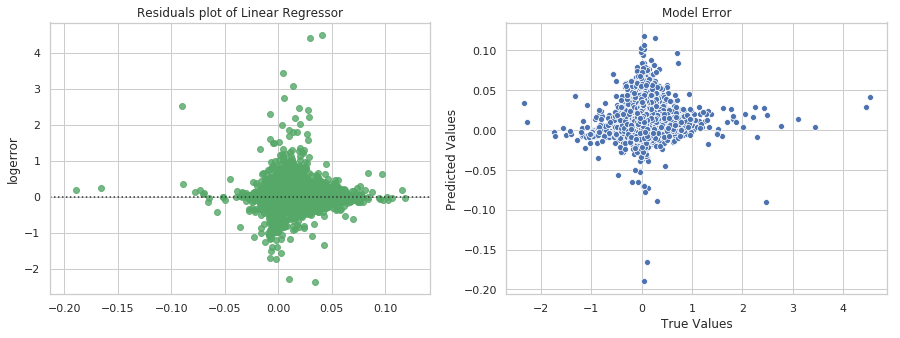

In [46]:
print("Running Linear Regressor...")
model_lr = linearRegressor(X_train, Y_train, X_test, Y_test)
submitPredictions(model_lr.predict(test_df[X_train.columns.values]), "LR")

### Executar um dos grid search definidos acima de acordo com o valor definido da variável

In [47]:
if (grid_search == "Default"):
    defaultXGB(X_train, Y_train, X_test, Y_test) 
    defaultRFR(X_train, Y_train, X_test, Y_test)

In [48]:
if (grid_search == "RFR"):
    print("Running Random Forest Regressor...")
    model_rfr = randomForestRegressor(X_train, Y_train, X_test, Y_test)
    submitPredictions(model_rfr.predict(test_df[X_train.columns.values]), "RFR")

In [49]:
if (grid_search == "XGB"):
    print("Running XGBoost...")
    model_xgb = xgb(X_train, Y_train, X_test, Y_test)
    submitPredictions(model_xgb.predict(test_df[X_train.columns.values]), "XGB")

In [50]:
if (grid_search == "TPOT"):
    tpotRegressor(X_train, Y_train, X_test, Y_test)

# Caso não se deseje executar grid search, submeter os resultados dos melhores modelos

Using Best Random Forest Regressor Model...
Erro médio absoluto: 0.07901866132488992

Writing results to disk ...
Using Best XGBoost Regressor Model...
Erro médio absoluto: 0.07696229829133656

Writing results to disk ...
Using Best TPOT Model (Linear SVR)...
Erro médio absoluto: 0.07554527577620643

Writing results to disk ...


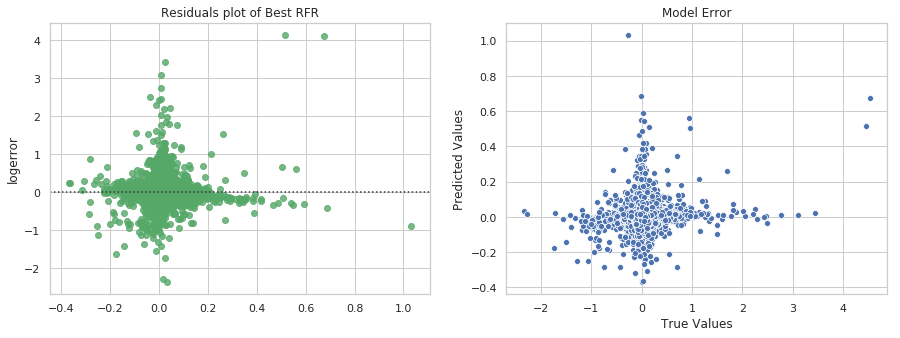

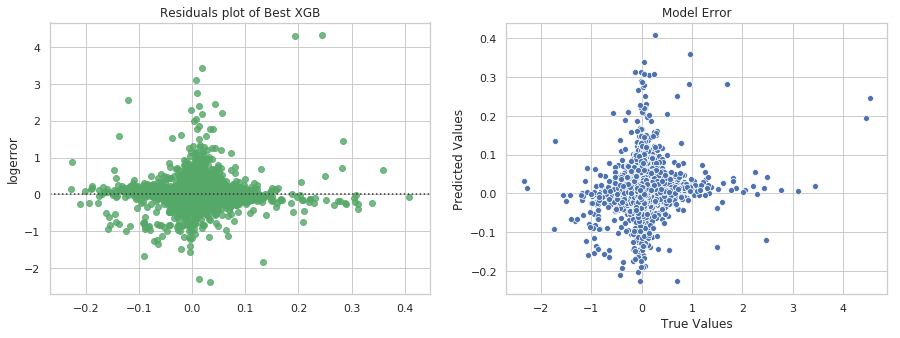

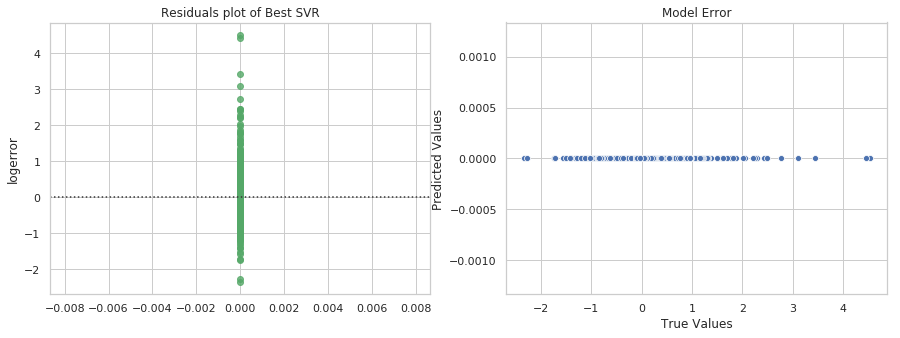

In [51]:
if (grid_search == "Best"):
    submitBestModelRFR(X_train, Y_train, X_test, Y_test)
    submitBestModelXGB(X_train, Y_train, X_test, Y_test)
    submitBestModelTPOT(X_train, Y_train, X_test, Y_test)

In [52]:
#Retorno do TPOT
'''
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR

# NOTE: Make sure that the class is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1).values
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'].values, random_state=None)

# Average CV score on the training set was:-0.0678352369864653
exported_pipeline = LinearSVR(C=0.1, dual=True, epsilon=1.0, loss="squared_epsilon_insensitive", tol=0.0001)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)
'''

'\nimport numpy as np\nimport pandas as pd\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.svm import LinearSVR\n\n# NOTE: Make sure that the class is labeled \'target\' in the data file\ntpot_data = pd.read_csv(\'PATH/TO/DATA/FILE\', sep=\'COLUMN_SEPARATOR\', dtype=np.float64)\nfeatures = tpot_data.drop(\'target\', axis=1).values\ntraining_features, testing_features, training_target, testing_target =             train_test_split(features, tpot_data[\'target\'].values, random_state=None)\n\n# Average CV score on the training set was:-0.0678352369864653\nexported_pipeline = LinearSVR(C=0.1, dual=True, epsilon=1.0, loss="squared_epsilon_insensitive", tol=0.0001)\n\nexported_pipeline.fit(training_features, training_target)\nresults = exported_pipeline.predict(testing_features)\n'

Os modelos foram avaliados de acordo com o score retornado pela submissão ao kaggle do conjunto de testes.
Apesar de o desempenho do modelo de Regressão Linear ser bom no conjunto de treinamento, quando utilizado o conjunto de testes ele apresentou o pior desempenho. 


## Regressor usando Redes Neurais

In [53]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

In [54]:
def submitNeuralNetwork(X_train, X_test, Y_train, Y_test):
    
    print("Using Neural Network ...")
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    
    rn_regressor = MLPRegressor(hidden_layer_sizes = (350,200,120,),early_stopping = True)
    rn_regressor.fit(X_train_sc, Y_train)
    
    predictions_rn = rn_regressor.predict(X_test_sc)
    
    # Visualizing model performance on training dataset
    # Results for the training dataset
    resultados(Y_test, predictions_rn, "Neural Network")

    # Testing the model on test dataframe and submiting results
    #submitPredictions(rn_regressor.predict(test_df[X_train.columns.values]), "Neural_Network")

Using Neural Network ...
Erro médio absoluto: 0.07763090745835889


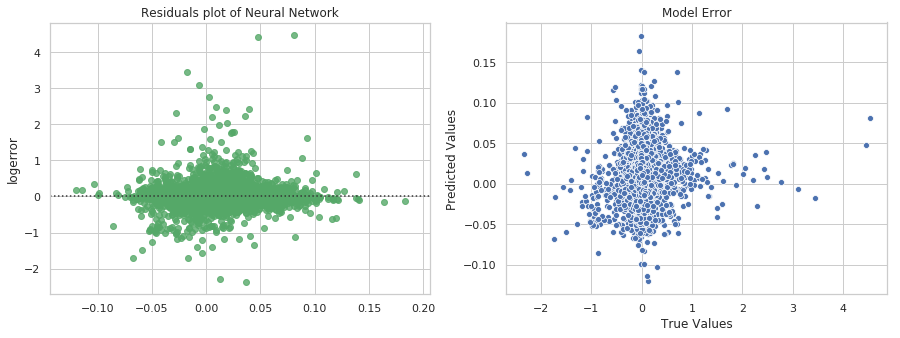

In [55]:
submitNeuralNetwork(X_train, X_test, Y_train, Y_test)

## Grid Search com Redes Neurais

In [56]:
def NeuralNetwork_gs(X_train, X_test, Y_train, Y_test):
    
    cv_sets = ShuffleSplit(n_splits=5, test_size = 0.25)
    
    print("Using Neural Network with Grid Search...")
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)

    rn_regressor = MLPRegressor()

    # neural network params
    params = {
        'hidden_layer_sizes':[(150,100,),(200,150,100,),(300,200,100)],
        'activation':['relu'],
        'solver':['sgd','adam'],
        'learning_rate': ['constant','adaptive'],
        'learning_rate_init':[.001],
        'early_stopping':[True]
    }

    # Gerar o objeto de busca em matriz
    grid = GridSearchCV(estimator = rn_regressor, param_grid = params, scoring='neg_mean_squared_error',cv=cv_sets, verbose=2,n_jobs = -1)

    grid = grid.fit(X_train_sc, Y_train)

    # Escolher o melhor estimador para predizer os dados de teste
    best_model = grid.best_estimator_

    print("Best Estimator: \n{}\n".format(grid.best_estimator_))
    print("Best Parameters: \n{}\n".format(grid.best_params_))

    pred_rn = best_model.predict(X_test_sc)
  
    resultados(Y_test, pred_rn, "MLP Regressor")

    # Returns the trained model
    return best_model
    

In [57]:
if (grid_search == "MLPR"):
    rn_model = NeuralNetwork_gs(X_train, X_test, Y_train, Y_test)